#### This notebook contains implementation of Bio-Bert and Roberta Models for multi-label classification on the pubmed data-set.  

In [65]:
import os
import wandb
import torch
import pickle
import numpy as np
%matplotlib inline

import pandas as pd

# import gradio as gr
import seaborn as sns
import tensorflow as tf

from typing import Dict
from ast import literal_eval
from torch.optim import AdamW
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from kaggle_secrets import UserSecretsClient
from torch.nn import BCEWithLogitsLoss, BCELoss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
from transformers import XLNetForSequenceClassification, XLNetTokenizer,BertForSequenceClassification,BertTokenizer, RobertaForSequenceClassification,RobertaTokenizer

In [66]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import warnings
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pubmed-multilabel-text-classification/PubMed Multi Label Text Classification Dataset Processed.csv
/kaggle/input/pubmed-multilabel-text-classification/PubMed Multi Label Text Classification Dataset.csv
/kaggle/input/training-batch-800-809csv/training_batch_800_809.csv


In [67]:
# !wget --header="Host: northeastern-my.sharepoint.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36 Edg/107.0.1418.56" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://northeastern-my.sharepoint.com/personal/choudhari_p_northeastern_edu/_layouts/15/onedrive.aspx" --header="Cookie: MicrosoftApplicationsTelemetryDeviceId=48f04ca2-c4e6-0958-1183-50f51b84c217; MicrosoftApplicationsTelemetryFirstLaunchTime=1663628373112; ExcelWacDataCenter=PUS4; WacDataCenter=PUS4; PowerPointWacDataCenter=PUS4; SIMI=eyJzdCI6MH0=; rtFa=d/ticyP8j8Hk6o+X27HQ4F7ITVswmt12qS/hzeOshismQThFRUMyODEtQUFBMy00REFFLUFDOUItOUEzOThCOTIxNUU3IzEzMzEzMTg1NDU4NzUzMjk1MSM3MTkyNzlBMC0zMDlFLTIwMDAtRDQxMi0zQUNDMjAxQUZDMUUjQ0hPVURIQVJJLlAlNDBOT1JUSEVBU1RFUk4uRURVTSgneEtDD7sCQSG3gpdkZJYFci5yTYCtz7YVLHHd1HkukB/GqGkwgUNWzPi9UXIqDPbn0D1ogMq3mWNn+jCx1JVX78CJa0UyxkIdjauHLNMBk24IwrtVEdpGKRwbUxLARY7BL7PuCbCY7yRlOToZZ5NBIBQa7SnF86CdyxH4IPImz7VNV97JitlcC+6Tic+z3ySDGU1fFAB/fqMMKmiCY0ph9Zyh+J3xMdyolBaXlJFV70JS6M+Vn0LON3PE4UrO4BVZv9gjmtT5fe7M4iLABbGw1kqgCCPvy8i1dXAjkYobJ0FMibz33vMHk5ISrzBi8HIRblYEPhahwRx6g++7B5wAAAA=; FedAuth=77u/PD94bWwgdmVyc2lvbj0iMS4wIiBlbmNvZGluZz0idXRmLTgiPz48U1A+VjEyLDBoLmZ8bWVtYmVyc2hpcHwxMDAzMjAwMDdjNGMzMDQxQGxpdmUuY29tLDAjLmZ8bWVtYmVyc2hpcHxjaG91ZGhhcmkucEBub3J0aGVhc3Rlcm4uZWR1LDEzMzA4MzE4MzA4MDAwMDAwMCwxMzI4MzMwNTk4NTAwMDAwMDAsMTMzMTQyMTg4ODIxNDE4MDc4LDczLjIzNC4xMjIuMjUxLDY3LGE4ZWVjMjgxLWFhYTMtNGRhZS1hYzliLTlhMzk4YjkyMTVlNywsZDcxNDlhZDQtNDkyNC00NmJjLTgyOTMtMDU2MTkxOTlkMGY3LDcxOTI3OWEwLTMwOWUtMjAwMC1kNDEyLTNhY2MyMDFhZmMxZSwwMWQwN2JhMC00MDc1LTIwMDAtZjQzZS00ODc2NGYxZGI3ZDYsLDAsMTMzMTM3OTA0ODIxMjYyMTQ1LDEzMzE0MDQ2MDgyMTI2MjE0NSwsLGV5SjRiWE5mWTJNaU9pSmJYQ0pEVURGY0lsMGlMQ0o0YlhOZmMzTnRJam9pTVNJc0ltRmpjbk1pT2lKYlhDSjFjbTQ2ZFhObGNqcHlaV2RwYzNSbGNuTmxZM1Z5YVhSNWFXNW1iMXdpWFNJc0luQnlaV1psY25KbFpGOTFjMlZ5Ym1GdFpTSTZJbU5vYjNWa2FHRnlhUzV3UUc1dmNuUm9aV0Z6ZEdWeWJpNWxaSFVpTENKMWRHa2lPaUpPWW1SdVIwSldRVXByTWt0WE9GOXNOM1JKTlVGQkluMD0sMTMzMTMxODkwNTg3MjIwNDQwLDEzMzEzMTg1NDU4MDAwMDAwMCxjNjJhNTNhYy1iMGZkLTQyNDQtYmE3MC1kODQ1YmEwOTMwY2QsLCwsLCwwLCxHVXQ5UlpNYVhYVE9ENWZoK09yMDd6endwZWcyQXdZc3IxQ2JpeHkvc3BLam01OG5JZE12UW4xUFc2dlFWcjJjOUhYK2dnZGd3V0l3L1BuWWhnS25odms3UmQ0VU1DSVBZSnQ4b0VpUjNhL2hJWktTM3BJOHR3VFcwbzRqQThkTXZrOENSODU0Q0UwY0tha0YzRUNqSWJlMnMwMHRxWXdzVThxZjdxL2dLZVBySy9KKzEzV0xDVE9sREk5TmFiRXRCRHdDWU5ic2JYbU1wbFVwQUx5aVBwM2NDQURvTmxqSVB6NmdOSFpiOWg1WHdoMlFlcXhUdzlla3BvSGRJMHF6UDVwVnFCZ1JkKzF2dHdYc3VnS0RaUFNEbGRZWWtsZUZKcFBJd0FoUnFRazgxM2pMRlBTNHNtVWF0WDhNZWhCckNuVTcrVStXaHJXTk1nTG9nbkZkZUE9PTwvU1A+; odbn=1; WSS_FullScreenMode=false" --header="Connection: keep-alive" "https://northeastern-my.sharepoint.com/personal/choudhari_p_northeastern_edu/_layouts/15/download.aspx?UniqueId=e12465f9%2De777%2D449b%2D872d%2De2305eaed74f" -c -O 'training_batch_800_809.csv'

In [68]:
torch.__version__

'1.11.0'

In [69]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2022-11-29 23:45:27.053606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 23:45:27.054584: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 23:45:27.055202: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 23:45:27.055901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 23:45:27.056465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [2]:
dataset_Name = '/kaggle/input/training-batch-800-809csv/training_batch_800_809.csv'
# dataset_Name = 'training_batch_800_809.csv'

df= pd.read_csv(dataset_Name) #.head(1000)
df.head()

,PMID,date_completed,NumberOfReferences,AbstractText,ArticleTitle,AuthorList,A,B,C,D,...,F,G,H,I,J,K,L,M,N,Z
0,25192366,2021-06-25,0,"The link between obesity and diabetes, hyperte...",Trends in Body-Mass Index After Donor Nephrect...,"{'Author': {'LastName': ['Movassaghi', 'Dru', ...",1,1,0,0,...,0,1,0,0,0,0,0,1,1,0
1,25100380,2019-04-16,0,To investigate nutritive microvascular functio...,Nonobese Young Females with Polycystic Ovary S...,"{'Author': {'LastName': ['Leão', 'Maranhão', '...",0,1,1,1,...,0,1,0,0,0,0,0,1,1,0
2,25100370,2019-04-16,0,To estimate the prevalence and clinical profil...,Clinical profile of nonalcoholic Fatty liver d...,"{'Author': {'LastName': ['Vendhan', 'Amutha', ...",0,1,1,0,...,0,1,0,0,0,0,0,0,1,1
3,25293969,2018-02-01,0,"The MOVE!23, a questionnaire to assess weight-...",Psychometric properties of a MOVE!23 subscale:...,"{'Author': {'LastName': ['Higgins', 'Buta', 'D...",0,1,1,0,...,1,1,0,0,0,0,0,1,1,1
4,25081820,2018-01-16,0,Rates of obesity are increasing in women of ch...,Increased maternal BMI is associated with infa...,"{'Author': {'LastName': ['de Vries', 'Reynolds...",1,1,1,1,...,1,1,0,0,0,0,0,1,1,1


In [71]:
print("Total number of Articles extracted from Bioasq dataset are =",len(df))
print('Average Article length: ', df.AbstractText.str.split().str.len().mean())
print('Stdev Article length: ', df.AbstractText.str.split().str.len().std())

Total number of Articles extracted from Bioasq dataset are = 1000
Average Article length:  80.672
Stdev Article length:  81.92090973281151


In [72]:
cols = df.columns
cols = list(df.columns)

# might have to change depending on categories 
mesh_Heading_categories = cols[6:]
num_labels = len(mesh_Heading_categories)
print('Mesh Labels Root Class: \n',mesh_Heading_categories)
print('Number of Labels: ' ,num_labels)

Mesh Labels Root Class: 
 ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'Z']
Number of Labels:  15


#### Visualisation

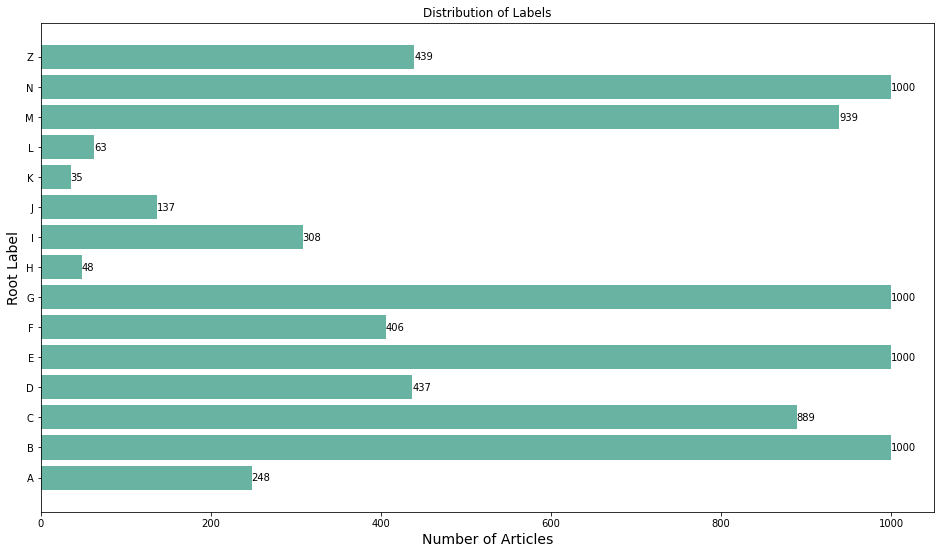

In [73]:
counts = []
for mesh_Heading_category in mesh_Heading_categories:
    counts.append((mesh_Heading_category, df[mesh_Heading_category].sum()))
df_count = pd.DataFrame(counts, columns=['root_label', 'num_of_abstract'])

plt.figure(figsize=(16,9))

bars = plt.barh(df_count['root_label'],df_count['num_of_abstract'],color='#69b3a2')
plt.title("Distribution of Labels")
plt.xlabel('Number of Articles', fontsize=14)
plt.ylabel('Root Label', fontsize=14)

plt.bar_label(bars)
plt.show()

#### Word Cloud

In [1]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

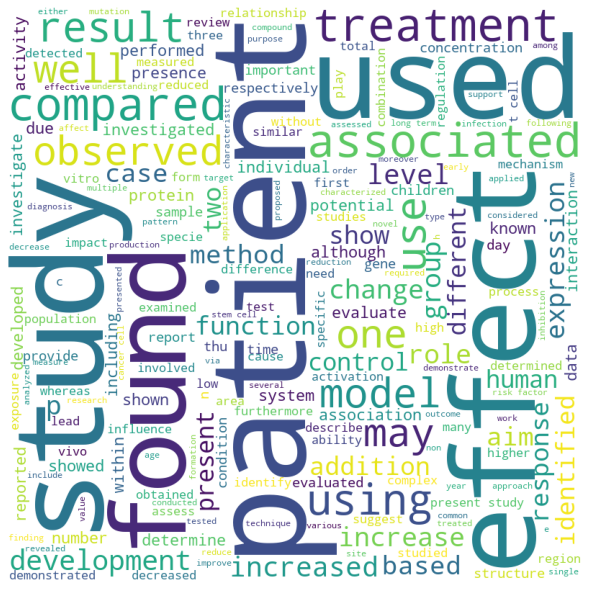

In [3]:
comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df.AbstractText:
	
	# typecaste each val to string
	val = str(val)

	# split the value
	tokens = val.split()
	
	# Converts each token into lowercase
	for i in range(len(tokens)):
		tokens[i] = tokens[i].lower()
	
	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
				background_color ='white',
				stopwords = stopwords,
				min_font_size = 10).generate(comment_words)

# plot the WordCloud image					
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


In [104]:
df_train, df_test = train_test_split(df, random_state=32, test_size=0.20, shuffle=True)

print(df_train.shape)
print(df_test.shape)

(800, 21)
(200, 21)


In [75]:
df_train['one_hot_labels'] = list(df_train[mesh_Heading_categories].values)
df_train.head()

,PMID,date_completed,NumberOfReferences,AbstractText,ArticleTitle,AuthorList,A,B,C,D,...,G,H,I,J,K,L,M,N,Z,one_hot_labels
799,25222360,2015-10-02,0,Hyperandrogenic conditions in women are associ...,The role of serum testosterone in early pregna...,"{'Author': {'LastName': ['Lathi', 'Dahan', 'Re...",0,1,1,1,...,1,0,1,0,0,0,1,1,1,"[0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1]"
471,25217824,2015-12-28,0,To examine the relationship between physical a...,"Relationship between physical activity, knee m...","{'Author': {'LastName': ['Winberg', 'Flansbjer...",1,1,1,0,...,1,0,0,0,0,0,1,1,0,"[1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0]"
242,25223750,2016-05-16,0,Perception of body size is a key factor drivin...,Size misperception among overweight and obese ...,"{'Author': {'LastName': ['Paul', 'Sciacca', 'B...",0,1,1,0,...,1,0,0,0,0,0,1,1,0,"[0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0]"
704,25085333,2015-10-26,0,Endoscopic volume reduction of the stomach may...,Endoscopic gastric volume reduction with a nov...,"{'Author': {'LastName': ['Verlaan', 'Paulus', ...",0,1,1,0,...,1,0,0,0,0,0,1,1,0,"[0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0]"
839,25236175,2015-09-16,0,To measure changes in resting metabolic rate (...,Metabolic adaptation following massive weight ...,"{'Author': {'LastName': ['Knuth', 'Johannsen',...",0,1,1,1,...,1,0,0,0,0,0,1,1,0,"[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0]"


In [76]:
labels = list(df_train.one_hot_labels.values)
Article_train = list(df_train.AbstractText.values)

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [78]:
# # Identifying indices of 'one_hot_labels' entries that only occur once - this will allow me to stratify split our training data later
# label_counts = df_train.one_hot_labels.astype(str).value_counts()
# one_freq = label_counts[label_counts==1].keys()
# one_freq_idxs = sorted(list(df_train[df_train.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
# print(len(one_freq_idxs))

In [80]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'

In [81]:
def train_model(model,train_dataloader,validation_dataloader,optimizer, epochs = 8):
    
    
    # Number of training epochs (Orignal author's recommend between 10 and 20)
#     epochs = 12

    # trange is a tqdm wrapper around the normal python range
    for _ in trange(epochs, desc="Epoch "):
        # Training

        # Set our model to training mode (as opposed to evaluation mode)
        model.train()

        # Tracking variables
        tr_loss = 0 #running loss
        nb_tr_examples, nb_tr_steps = 0, 0

        # Train the data for one epoch
        for step, batch in enumerate(train_dataloader):
            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            # Unpack the inputs from our dataloader
            b_input_ids, b_input_mask, b_labels= batch
            # Clear out the gradients (by default they accumulate)
            optimizer.zero_grad()

            # Forward pass for multilabel classification
            # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss
            # Creates a criterion that measures the Binary Cross Entropy between the target and the input probabilities
            # Also This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable 
            # than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the 
            # log-sum-exp trick for numerical stability.
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs[0]
            loss_func = BCEWithLogitsLoss() 
            loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation

            train_loss_set.append(loss.item())    

            # Backward pass
            loss.backward()
            # Update parameters and take a step using the computed gradient
            optimizer.step()
            # scheduler.step()
            # Update tracking variables
            tr_loss += loss.item()
            nb_tr_examples += b_input_ids.size(0)
            nb_tr_steps += 1

        print("Train loss: {}".format(tr_loss/nb_tr_steps))
        training_loss_list.append(tr_loss/nb_tr_steps)

        ###############################################################################

        # Validation

        # Put model in evaluation mode to evaluate loss on the validation set
        model.eval()

        # Variables to gather full output
        logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

        # Predict
        for i, batch in enumerate(validation_dataloader):
            batch = tuple(t.to(device) for t in batch)
            # Unpack the inputs from our dataloader
            b_input_ids, b_input_mask, b_labels = batch
            with torch.no_grad():
                # Forward pass
                outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
                b_logit_pred = outs[0]
                pred_label = torch.sigmoid(b_logit_pred)

            b_logit_pred = b_logit_pred.detach().cpu().numpy()
            pred_label = pred_label.to('cpu').numpy()
            b_labels = b_labels.to('cpu').numpy()

        tokenized_texts.append(b_input_ids)
        logit_preds.append(b_logit_pred)
        true_labels.append(b_labels)
        pred_labels.append(pred_label)

        # Flatten outputs
        pred_labels = [item for sublist in pred_labels for item in sublist]
        true_labels = [item for sublist in true_labels for item in sublist]

        # Calculate Accuracy
        threshold = 0.50
        pred_bools = [pl>threshold for pl in pred_labels]
        true_bools = [tl==1 for tl in true_labels]
        val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
        val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

        print('F1 Validation Accuracy: ', val_f1_accuracy)  
        print('Flat Validation Accuracy: ', val_flat_accuracy)
        print('\n')
        val_f1_accuracy_list.append(val_f1_accuracy)
        val_flat_accuracy_list.append(val_flat_accuracy)
        epochs_list.append(epochs) 
        
    pass
        

## Roberta

In [82]:
max_length = 128
model_name = 'roberta'
tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base', do_lower_case=False)  # tokenizer
# tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.2', do_lower_case=True) 


encodings = tokenizer.batch_encode_plus(Article_train,max_length=max_length,padding=True,truncation=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks

tokenizer outputs:  dict_keys(['input_ids', 'attention_mask'])


In [83]:
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=2020, test_size=0.20)

# Convert all of our data into torch tensors, the required datatype for our BERT Pytorch model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)


##########
batch_size = 64

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data =     TensorDataset(train_inputs, train_masks, train_labels,)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels,)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

##########
#Tried Several Models Locally XLNet was performing Best. Note If you are changing the model then change the Tokenizer also
model = RobertaForSequenceClassification.from_pretrained('distilroberta-base', num_labels=num_labels)
# model = BertForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.2", num_labels=num_labels)

model.cuda()
print('Model Pushed to Cuda for Training')

#############
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters,lr=6e-6)



Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias

Model Pushed to Cuda for Training


In [84]:
# For Storing our loss and accuracy for plotting
train_loss_set = []
val_f1_accuracy_list,val_flat_accuracy_list,training_loss_list,epochs_list=[],[],[],[]

train_model(model,train_dataloader,validation_dataloader,optimizer, epochs = 8)

Epoch :   0%|          | 0/8 [00:00<?, ?it/s]

Train loss: 0.6782825469970704


Epoch :  12%|█▎        | 1/8 [00:06<00:45,  6.49s/it]

F1 Validation Accuracy:  65.16007532956685
Flat Validation Accuracy:  0.0


Train loss: 0.6495811998844147


Epoch :  25%|██▌       | 2/8 [00:12<00:38,  6.48s/it]

F1 Validation Accuracy:  78.66927592954991
Flat Validation Accuracy:  0.0


Train loss: 0.5898180782794953


Epoch :  38%|███▊      | 3/8 [00:19<00:32,  6.50s/it]

F1 Validation Accuracy:  85.33333333333333
Flat Validation Accuracy:  0.0


Train loss: 0.5143755108118058


Epoch :  50%|█████     | 4/8 [00:26<00:26,  6.53s/it]

F1 Validation Accuracy:  84.96732026143789
Flat Validation Accuracy:  3.125


Train loss: 0.4583339333534241


Epoch :  62%|██████▎   | 5/8 [00:32<00:19,  6.57s/it]

F1 Validation Accuracy:  85.33333333333333
Flat Validation Accuracy:  0.0


Train loss: 0.42160192131996155


Epoch :  75%|███████▌  | 6/8 [00:39<00:13,  6.62s/it]

F1 Validation Accuracy:  85.07795100222717
Flat Validation Accuracy:  0.0


Train loss: 0.3985065221786499


Epoch :  88%|████████▊ | 7/8 [00:46<00:06,  6.67s/it]

F1 Validation Accuracy:  85.33333333333333
Flat Validation Accuracy:  3.125


Train loss: 0.3843531906604767


Epoch : 100%|██████████| 8/8 [00:52<00:00,  6.62s/it]

F1 Validation Accuracy:  85.58758314855876
Flat Validation Accuracy:  3.125




In [85]:
num_epochs = np.arange(1,len(training_loss_list)+1)
model_name_ls = [model_name]*len(training_loss_list)
df_train_results = pd.DataFrame({'Epochs':num_epochs,'F1 Validation Accuracy':val_f1_accuracy_list,\
                               'Flat Validation Accuracy':val_flat_accuracy_list,'Train loss':training_loss_list, 'model_name':model_name_ls})

df_train_results

,Epochs,F1 Validation Accuracy,Flat Validation Accuracy,Train loss,model_name
0,1,65.160075,0.000,0.678283,roberta
1,2,78.669276,0.000,0.649581,roberta
2,3,85.333333,0.000,0.589818,roberta
3,4,84.967320,3.125,0.514376,roberta
4,5,85.333333,0.000,0.458334,roberta
5,6,85.077951,0.000,0.421602,roberta
6,7,85.333333,3.125,0.398507,roberta
7,8,85.587583,3.125,0.384353,roberta


(0.0, 100.0)

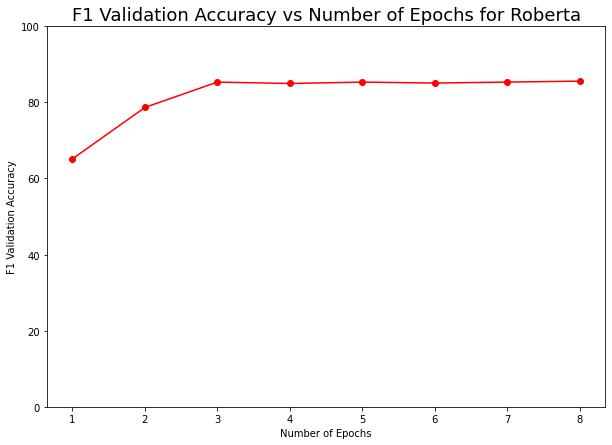

In [86]:
fig, ax = plt.subplots(figsize=(10, 7));
ax.plot(num_epochs, np.array(val_f1_accuracy_list),'ro-' ,label="F1 Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("F1 Validation Accuracy")
ax.set_title("F1 Validation Accuracy vs Number of Epochs for Roberta",fontsize=18)
ax.set_ylim(0, 100)

In [87]:
df_train_results.to_csv("/kaggle/working/roberta_results.csv")
torch.save(model,"roberta_model")

## Bio-Bert

In [88]:
max_length = 128
model_name = 'biobert'

#tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base', do_lower_case=False)  # tokenizer
tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.2', do_lower_case=True) 


encodings = tokenizer.batch_encode_plus(Article_train,max_length=max_length,padding=True,truncation=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks



train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=2020, test_size=0.20)


# Convert all of our data into torch tensors, the required datatype for our BERT Pytorch model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)


batch_size = 64

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data =     TensorDataset(train_inputs, train_masks, train_labels,)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels,)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [89]:
#Tried Several Models Locally XLNet was performing Best. Note If you are changing the model then change the Tokenizer also
# model = RobertaForSequenceClassification.from_pretrained('distilroberta-base', num_labels=num_labels)
model = BertForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.2", num_labels=num_labels)

model.cuda()
print('Model Pushed to Cuda for Training')

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters,lr=6e-6)

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

Model Pushed to Cuda for Training


In [90]:
# For Storing our loss and accuracy for plotting
train_loss_set = []
val_f1_accuracy_list,val_flat_accuracy_list,training_loss_list,epochs_list=[],[],[],[]

train_model(model,train_dataloader,validation_dataloader,optimizer, epochs = 8)

Epoch :   0%|          | 0/8 [00:00<?, ?it/s]

Train loss: 0.6385839402675628


Epoch :  12%|█▎        | 1/8 [00:13<01:34, 13.46s/it]

F1 Validation Accuracy:  78.45303867403315
Flat Validation Accuracy:  0.0


Train loss: 0.5853201627731324


Epoch :  25%|██▌       | 2/8 [00:27<01:21, 13.57s/it]

F1 Validation Accuracy:  83.26693227091634
Flat Validation Accuracy:  3.125


Train loss: 0.5416771471500397


Epoch :  38%|███▊      | 3/8 [00:41<01:08, 13.72s/it]

F1 Validation Accuracy:  82.88659793814432
Flat Validation Accuracy:  3.125


Train loss: 0.49976855516433716


Epoch :  50%|█████     | 4/8 [00:55<00:55, 13.90s/it]

F1 Validation Accuracy:  83.33333333333334
Flat Validation Accuracy:  3.125


Train loss: 0.4605445235967636


Epoch :  62%|██████▎   | 5/8 [01:09<00:42, 14.02s/it]

F1 Validation Accuracy:  83.08977035490605
Flat Validation Accuracy:  3.125


Train loss: 0.43035765588283537


Epoch :  75%|███████▌  | 6/8 [01:23<00:28, 14.06s/it]

F1 Validation Accuracy:  83.58208955223881
Flat Validation Accuracy:  3.125


Train loss: 0.4117045044898987


Epoch :  88%|████████▊ | 7/8 [01:37<00:14, 14.04s/it]

F1 Validation Accuracy:  84.58149779735682
Flat Validation Accuracy:  3.125


Train loss: 0.3947905361652374


Epoch : 100%|██████████| 8/8 [01:51<00:00, 13.94s/it]

F1 Validation Accuracy:  85.33333333333333
Flat Validation Accuracy:  3.125




In [91]:
num_epochs = np.arange(1,len(training_loss_list)+1)
model_name_ls = [model_name]*len(training_loss_list)
df_train_results_bert=pd.DataFrame({'Epochs':num_epochs,'F1 Validation Accuracy':val_f1_accuracy_list,\
                               'Flat Validation Accuracy':val_flat_accuracy_list,'Train loss':training_loss_list, 'model_name':model_name_ls})


df_train_results = df_train_results.append(df_train_results_bert)
df_train_results.to_csv("val_results.csv")

In [92]:
df_train_results

,Epochs,F1 Validation Accuracy,Flat Validation Accuracy,Train loss,model_name
0,1,65.160075,0.000,0.678283,roberta
1,2,78.669276,0.000,0.649581,roberta
2,3,85.333333,0.000,0.589818,roberta
3,4,84.967320,3.125,0.514376,roberta
4,5,85.333333,0.000,0.458334,roberta
5,6,85.077951,0.000,0.421602,roberta
6,7,85.333333,3.125,0.398507,roberta
7,8,85.587583,3.125,0.384353,roberta
0,1,78.453039,0.000,0.638584,biobert
1,2,83.266932,3.125,0.585320,biobert


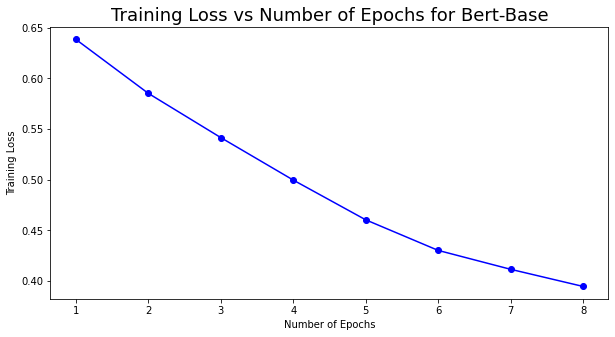

In [93]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(training_loss_list) ,'bo-',label="Train Loss")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Training Loss")
ax.set_title("Training Loss vs Number of Epochs for Bert-Base",fontsize=18)
plt.show()

(0.0, 100.0)

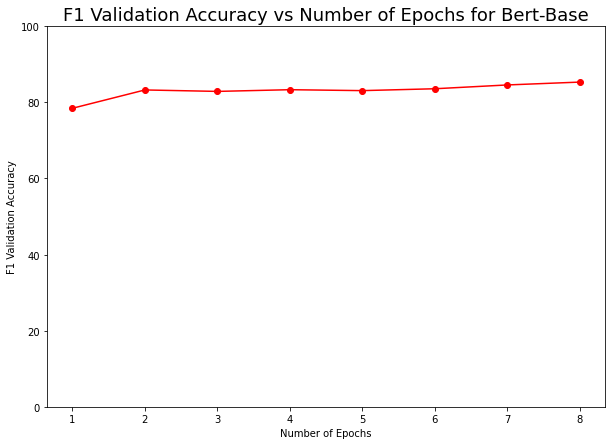

In [94]:
fig, ax = plt.subplots(figsize=(10, 7));
ax.plot(num_epochs, np.array(val_f1_accuracy_list),'ro-' ,label="F1 Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("F1 Validation Accuracy")
ax.set_title("F1 Validation Accuracy vs Number of Epochs for Bert-Base",fontsize=18)
ax.set_ylim(0, 100)

(0.0, 100.0)

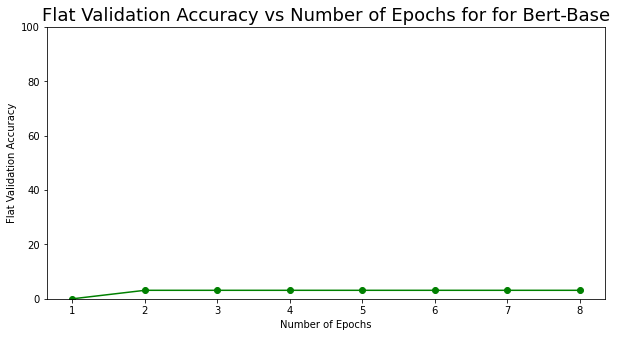

In [95]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(val_flat_accuracy_list),'go-', label="Flat Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Flat Validation Accuracy")
ax.set_title("Flat Validation Accuracy vs Number of Epochs for for Bert-Base",fontsize=18)
ax.set_ylim(0, 100)

In [105]:
df_test['one_hot_labels'] = list(df_test[mesh_Heading_categories].values)
df_test.head(3)

,PMID,date_completed,NumberOfReferences,AbstractText,ArticleTitle,AuthorList,A,B,C,D,...,G,H,I,J,K,L,M,N,Z,one_hot_labels
632,25183631,2015-11-16,0,It is unknown how the conflicting recommendati...,Predictors of screening for hyperlipidemia in ...,"{'Author': {'LastName': ['Montano', 'Witherell...",0,1,1,0,...,1,0,0,0,0,1,1,1,0,"[0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]"
687,25255383,2015-11-05,0,Whether being overweight or obese is associate...,Interactive effects of dietary fat/carbohydrat...,"{'Author': {'LastName': ['Chang', 'Chen', 'Owa...",0,1,1,1,...,1,0,0,1,0,0,1,1,1,"[0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1]"
833,25238605,2015-09-21,0,Recent cross-sectional studies have been repor...,Modest alcohol consumption reduces the inciden...,"{'Author': {'LastName': ['Hashimoto', 'Hamaguc...",0,1,1,0,...,1,0,0,0,0,0,1,1,0,"[0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0]"


In [106]:
test_labels = list(df_test.one_hot_labels.values)
Articles_test = list(df_test.AbstractText.values)
test_mesh_categories = list(df_test.columns[6:21])

test_encodings = tokenizer.batch_encode_plus(Articles_test,max_length=max_length,padding=True,truncation=True)
test_input_ids = test_encodings['input_ids']
test_attention_masks = test_encodings['attention_mask']

In [107]:
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels,)# test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

In [108]:
# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, = batch
    with torch.no_grad():
        # Forward pass
        outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        b_logit_pred = outs[0]
        pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

In [109]:
pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding
# Print and save classification report
Test_F1_Accuracy=f1_score(true_bools, pred_bools,average='micro')
Test_Flat_Accuracy= accuracy_score(true_bools, pred_bools)
print('Test F1 Accuracy: ',Test_F1_Accuracy )
print('Test Flat Accuracy: ',Test_Flat_Accuracy,'\n')

df_test=pd.DataFrame({'Test F1 Accuracy':Test_F1_Accuracy, 'Test Flat Accuracy':Test_Flat_Accuracy},index=[0])

print(classification_report(true_bools,pred_bools,target_names=test_mesh_categories))
clf_report = classification_report(true_bools,pred_bools,target_names=test_mesh_categories,output_dict=True)
df_report=pd.DataFrame(clf_report).transpose()

Test F1 Accuracy:  0.8430335097001764
Test Flat Accuracy:  0.095 

              precision    recall  f1-score   support

           A       0.00      0.00      0.00        54
           B       1.00      1.00      1.00       200
           C       0.88      1.00      0.94       176
           D       0.84      0.41      0.55        79
           E       1.00      1.00      1.00       200
           F       0.00      0.00      0.00        84
           G       1.00      1.00      1.00       200
           H       0.00      0.00      0.00        11
           I       0.00      0.00      0.00        61
           J       0.00      0.00      0.00        29
           K       0.00      0.00      0.00        11
           L       0.00      0.00      0.00        15
           M       0.92      1.00      0.96       183
           N       1.00      1.00      1.00       200
           Z       0.50      0.05      0.09        86

   micro avg       0.96      0.75      0.84      1589
   macro avg 

In [110]:
df_report.to_csv('Classification_Report.csv',index=False)

In [111]:
model.save_pretrained('./Multi_label_Classification_Save/')
tokenizer.save_pretrained('./Multi_label_Classification_Save/')

('./Multi_label_Classification_Save/tokenizer_config.json',
 './Multi_label_Classification_Save/special_tokens_map.json',
 './Multi_label_Classification_Save/vocab.txt',
 './Multi_label_Classification_Save/added_tokens.json')